In [1]:
#Dijkshtra Algorithm using FPGA

In [2]:
import pynq.lib.dma
import numpy as np

## There are fixed no of Vertices in the below example
vertices = 8
maxInt = 999999
## Load Overlay
overlay = pynq.Overlay("./dijkshtra.bit")
dijkshtra_IP = overlay.dijkshtra_0
regs = dijkshtra_IP.register_map


print("Compare Time taken by FPGA and CPU for Dijkshtra Computation:")

inpt = np.array([ [ 0, 4, 0, 0, 0, 0, 0, 8 ],
        [ 4, 0, 8, 0, 0, 0, 0, 11 ],
		[ 0, 8, 0, 7, 0, 4, 0, 0 ],
		[ 0, 0, 7, 0, 9, 14, 0, 0 ],
        [ 0, 0, 0, 9, 0, 10, 0, 0 ],
		[ 0, 0, 4, 14, 10, 0, 2, 0 ],
		[ 0, 0, 0, 0, 0, 2, 0, 1 ],
		[ 8, 11, 0, 0, 0, 0, 1, 0 ] ])

print("Input Map of Vertices and Distance : ")
print(inpt)

Compare Time taken by FPGA and CPU for Dijkshtra Computation:
Input Map of Vertices and Distance : 
[[ 0  4  0  0  0  0  0  8]
 [ 4  0  8  0  0  0  0 11]
 [ 0  8  0  7  0  4  0  0]
 [ 0  0  7  0  9 14  0  0]
 [ 0  0  0  9  0 10  0  0]
 [ 0  0  4 14 10  0  2  0]
 [ 0  0  0  0  0  2  0  1]
 [ 8 11  0  0  0  0  1  0]]


In [3]:
##Intermidiate Methods required for Implementation

def printSolution(dist):
    print ("Vertex \tDistance from Source")
    for node in range(vertices):
        print (node, "\t", dist[node])
  
    # A utility function to find the vertex with 
    # minimum distance value, from the set of vertices 
    # not yet included in shortest path tree
def minDistance(dist, sptSet):
    min = maxInt
    for v in range(vertices):
        if dist[v] < min and sptSet[v] == False:
            min = dist[v]
            min_index = v
  
    return min_index

In [4]:
## Method implemented for FPGA Computing

a = pynq.allocate(shape=(8,8), dtype=np.intc)
res = pynq.allocate(shape=(8), dtype=np.intc)

from operator import getitem, setitem

for j in range (8):
    setitem(a, j, inpt[j])
    
def dijkshtra_FPGA(inpt):
        
    regs.a_1 = a.device_address
    regs.res_1 = res.device_address

    regs.CTRL.AP_START = 1
    while regs.CTRL.AP_DONE == 0:
        pass
    
    #print("Output Distance from 1st Node Using FPGA: ")
    #printSolution(res)

In [5]:
def dijkshtra_CPU(inpt, src):
  
	dist = [999999] * vertices
	dist[src] = 0
	sptSet = [False] * vertices
	  
	for cout in range(vertices):
	  
		# Pick the minimum distance vertex from 
		# the set of vertices not yet processed. 
		# u is always equal to src in first iteration
		u = minDistance(dist, sptSet)
	  
		# Put the minimum distance vertex in the 
		# shotest path tree
		sptSet[u] = True
	  
		# Update dist value of the adjacent vertices 
		# of the picked vertex only if the current 
		# distance is greater than new distance and
		# the vertex in not in the shotest path tree
		for v in range(vertices):
			if (inpt[u][v] > 0 and sptSet[v] == False and dist[v] > dist[u] + inpt[u][v]):
				dist[v] = dist[u] + inpt[u][v]
 
	#print("Output Distance from 1st Node Using CPU: ")
	#printSolution(dist)

In [18]:
## Result Computation
from timeit import default_timer as t
data =  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
for i in range(4):
    start_time = t()
    dijkshtra_FPGA(inpt)
    fpga_time = t() - start_time

    start_time = t()
    dijkshtra_CPU(inpt,0)
    cpu_time = t() - start_time
    
    data[0][i] = fpga_time
    data[1][i] = cpu_time

In [19]:
## Result Comparison

# print("Time taken by FPGA :")
# print(fpga_time)
# print("Time taken by CPU :")
# print(cpu_time)

FPGA Output : 
Vertex 	Distance from Source
0 	 0
1 	 4
2 	 12
3 	 19
4 	 21
5 	 11
6 	 9
7 	 8


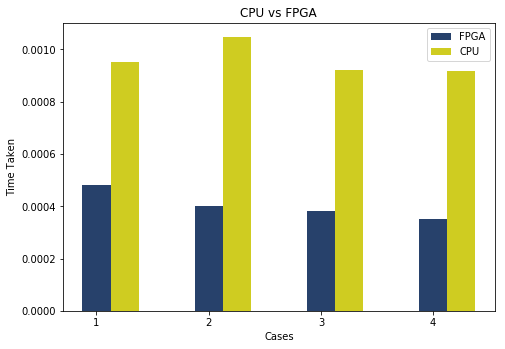

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

X = np.arange(1,5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = '#27416b', width = 0.25)
ax.bar(X + 0.25, data[1], color = '#cfcc21', width = 0.25)
ax.set_ylabel('Time Taken')
ax.set_xlabel('Cases')
ax.set_title('CPU vs FPGA')
ax.set_xticks(X)
ax.legend(labels=['FPGA', 'CPU'])

print("FPGA Output : ")
printSolution(res)